<div style="text-align:center"><img src="https://www.dropbox.com/s/roovx0dx8mpm4ep/ECE4076_banner.png?dl=1"></div>

<h1 align="center"> ECE4076/5176 - Week 10 </h1>
<h1 align="center"; style="color: purple;"> Here comes the AlexNet </h1>



You need to have the following packages to work with this notebook
- [pytorch](https://pytorch.org/)
- [numpy](https://anaconda.org/anaconda/numpy)
- [matplotlib](https://anaconda.org/conda-forge/matplotlib)
- [pillow](https://pillow.readthedocs.io/en/stable/)
- [requests](https://pypi.org/project/requests/)
- [captum](https://captum.ai/)
- [torchattacks](https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html)
- [scipy](https://scipy.org/)



In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import time
from datetime import timedelta
import requests

# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline

# you may need to install teh following package
# !pip install validators



<img src="https://pytorch.org/assets/images/pytorch-logo.png" width="100" />


PyTorch is an optimized tensor library for deep learning using GPUs and CPUs. It is nowadays the package used in academia and industry to develop deep learning models (along with TensorFlow, JAX, Keras). Below, we first check to see if we have access to an NVidia GPU or not. If you ahev a GPU, then processing required in this notebook will run much faster, if not, then no worries, you should still be able to go over all parts.

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


We will use a pretrained AlexNet in this notebook. Recall that AlexNet won the imagenet challenge. 
[Imagenet](https://www.image-net.org/update-mar-11-2021.php) is a dataset with 1,000 classes, let's have a look at the object classes in imagenet  

In [3]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

Scroll through the classes, how many do you know?



In [4]:
# the following function reads an image from a URL and displays it.
def read_image_from_url(url):
    img = Image.open(requests.get(url, stream=True).raw)
    img.thumbnail((256,256), Image.LANCZOS)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return img

Let's test the function above

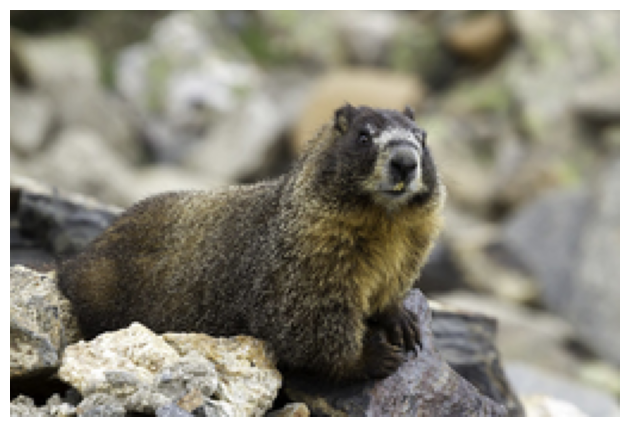

In [5]:
url = "https://live.staticflickr.com/7351/9416913997_df32c3b8ba_z.jpg"
img = read_image_from_url(url)

## AlexNet

AlexNet is an 8-layer CNN, a somewhat bigger version of LeNet (see the image below) designed by [Alex Krizhevsky](https://en.wikipedia.org/wiki/Alex_Krizhevsky) in collaboration with [Ilya Sutskever](https://en.wikipedia.org/wiki/Ilya_Sutskever) and [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton). Like many other DL-driven models, AlexNet is just one click (well, one line of code) away from you. See the code below.  

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/1200px-Comparison_image_neural_networks.svg.png" width="50%" />


In [6]:
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet.eval().to(device)

Using cache found in /home/michael/.cache/torch/hub/pytorch_vision_v0.10.0
/home/michael/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/michael/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

You should be able to recognize almost all the blocks in the network. You can use the pretrained model (which we will do) or retrain and repurpose it (which we don't do but feel free to take ECE4179/5179/6179 to learn how to do that!). To feed an image to AlexNet, we need to normalize it according to the way it was trained. For example, the image-size should be $3 \times 224 \times 224$. Also, RGB channels should be normalized (again, that is how the model was trained so we just need to follow accordingly). The function below takes care of that for us.

In [7]:
def Normalize_Image_AlexNet(img):
    # First we normalize the image. This is done by scaling the image to 256x256, 
    # followed by cropping the center part (224x244), and normalizing the RGB channels 
    preprocess = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])
    # PyTorch feeds its model in a certain way (here with a batch of images). 
    # The next few lines simply take care of that
    img_batch = preprocess(img)
    img_batch = img_batch.unsqueeze(0).to(device)
    return img_batch

def predict_with_AlexNet(img):
    
    img_batch = Normalize_Image_AlexNet(img)
    
    # next we feed the image to AlexNet. 
    # Note that the output of AlexNet (similar to many other trained models)
    # is the logits, showing predictions. Since we want to be able to interpret 
    # teh output as a probability vector, we need to include a softmax function at the end.
    with torch.no_grad():
        probabilities = F.softmax(alexnet(img_batch), dim=1)

    # We are going to just focus on the top5 predictions.
    # Again there are 1000 classes, so we really cannot bother ourselves with many classes    
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    top5_prob = top5_prob.to("cpu").numpy().flatten()
    top5_catid = top5_catid.to("cpu").numpy().flatten()

    for i, catid in enumerate(top5_catid):
        print(categories[catid], top5_prob[i]) 


Okay. If you don't know what the previous animal was (like me), let's ask AlexNet

In [8]:
predict_with_AlexNet(img)

marmot 0.99583024
beaver 0.0010526899
mongoose 0.0005653525
fox squirrel 0.0005223841
titi 0.0004506489


Hmm, Marmot. Should we check? Here is the [Wiki page](https://en.wikipedia.org/wiki/Marmot). Sounds about right! 
Now, before moving to the next part, you can try AlexNet yourself. The code below will get an image from an URL and uses AlexNet to predict the class of the image. Be creative, maybe check the classes of imagenet again and try to have some fun with an image of your own.

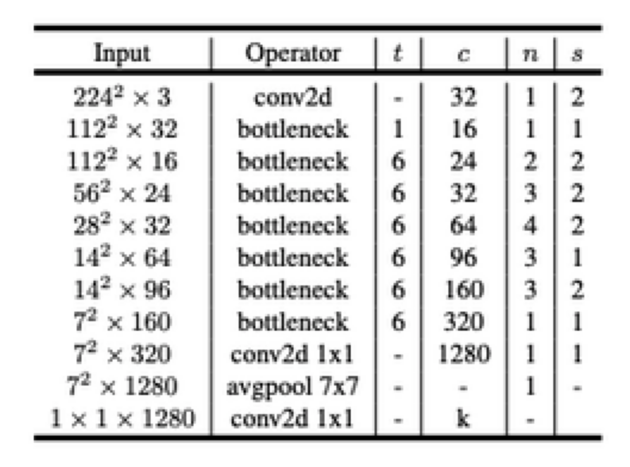

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [9]:
url = input("Enter the image URL: ")
img2 = read_image_from_url(url)
predict_with_AlexNet(img2)

Okay. Now, let's try to breakdown AlexNet. Do you think AlexNet can recognize if we rotate the image? 

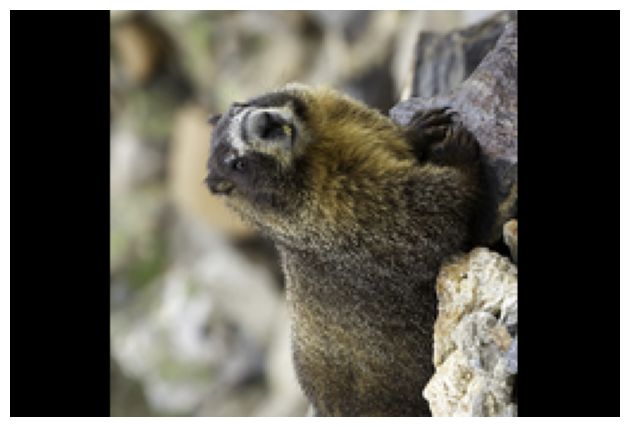

guenon 0.30015007
titi 0.23549794
indri 0.09208056
marmoset 0.062753975
Madagascar cat 0.060060933


In [10]:
img_rot = img.rotate(90)
# plotting
img_rot.thumbnail((256,256), Image.LANCZOS)
plt.imshow(img_rot)
plt.axis('off')
plt.tight_layout()
plt.show()

#feeding AlexNet with the rotated image
predict_with_AlexNet(img_rot)


Hold on, what happened? What is a Guenon?

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ac/Red-Eared_Guenon_at_CERCOPAN_sanctuary.JPG" width="300" />

According to [Wikipedia](https://en.wikipedia.org/wiki/Red-eared_guenon), a Guenon is a type of monkey, and as we can see from the picture, they're actually quite cute. Now, you may be wondering if there's any resemblance between the rotated marmot and a Guenon monkey. I'll leave that up to you to judge.

But let's move on to a more important question: if our model predicts a class, how can we identify which parts of the image are responsible for that particular prediction? This falls under the category of "Visualization and Interpretability" in deep learning. To answer this question, we'll use the captum package and a method called [Integrated Gradients](https://arxiv.org/abs/1703.01365). This is a popular approach for understanding CNNs. In short, the method backpropagates the gradient of a prediction to the input space, and adjusts the value of pixels to determine which ones contribute most to the prediction. This allows us to identify which parts of the image are most responsible for the prediction.

Let's see how it works in practice. We need to modify our predict function to work with the requirements of the captum package. I won't go into too much detail, but feel free to study the code below.


In [11]:
from captum.attr import IntegratedGradients
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

def IG_AlexNet(img):

    img_batch = Normalize_Image_AlexNet(img)
    # next we feed the image to AlexNet. 
    # Note that the output of AlexNet (similar to many other trained models)
    # is the logits, showing predictions. Since we want to be able to interpret 
    # teh output as a probability vector, we need to include a softmax function at the end.
    with torch.no_grad():
        probabilities = F.softmax(alexnet(img_batch), dim=1)

 
    prediction_score, pred_label_idx = torch.topk(probabilities, 1)

    integrated_gradients = IntegratedGradients(alexnet)
    ig_img_torch = integrated_gradients.attribute(img_batch, target=pred_label_idx, n_steps=200)
    
    

    img_np = np.transpose(img_batch.squeeze().cpu().detach().numpy(), (1,2,0))
    ig_img = np.transpose(ig_img_torch.squeeze().cpu().detach().numpy(), (1,2,0))
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

    _ = viz.visualize_image_attr(ig_img,img_np, method='blended_heat_map', 
                                 show_colorbar=True, sign='positive', 
                                 use_pyplot=True)
    
    


And here is the moment of truth

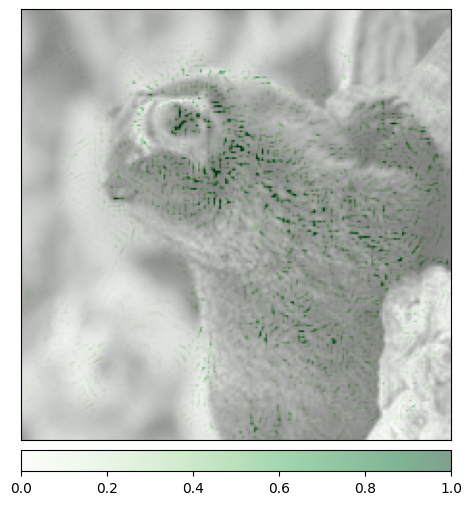

In [12]:
IG_AlexNet(img_rot)

Now, one possible interpretation of this, is that the examples of Guenon monkey in the dataset happen to mostly capture them standing (my poor language and engineering mind call it vertical monkey!). Both animals are furry and the form of their rotated face and nose are somehow similar (that is what I can see here at least). Anyways, this is somehow shocking. Now, do you want to know a secret? We can use the gradient to actually attack a neural network! How? Let's see. 



### Activity:

* Think about what you could do at training time to get around this issue? (Remember we spoke about invariances and data augmentation earlier in the unit)
* What would you lose by doing this?

In [15]:
# being lazy, I am not going to code the attack (which is merely a for-loop) but use a package
!pip install torchattacks

/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/home/michael/.local/lib/python3.8/site-packages/pkg_resources/__init__.py", line 3084, in _dep_map
    return self.__dep_map
  File "/home/michael/.local/lib/python3.8/site-packages/pkg_resources/__init__.py", line 2877, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/michael/.local/lib/python3.8/site-packages/pkg_resources/_vendor/packaging/requirements.py", line 35, in __init__
    parsed = _parse_requirement(requirement_string)
  File "/home/michael/.local/lib/python3.8/site-packages/pkg_resources/_vendor/packaging/_parser.py", line 64, in parse_requirement
    return _

In [16]:
import torch.nn as nn
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std



def Normalize_Image_FGSM(img):
    # First we normalize the image. This is done by scaling the image to 256x256, 
    # followed by cropping the center part (224x244), and normalizing the RGB channels 
    preprocess = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                    ])
    # PyTorch feeds its model in a certain way (here with a batch of images). 
    # The next few lines simply take care of that
    img_batch = preprocess(img)
    img_batch = img_batch.unsqueeze(0).to(device)
    return img_batch

# Adding a normalization layer for Resnet18.
# We can't use torch.transforms because it supports only non-batch images.
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

AlexNet_FGSM = nn.Sequential(norm_layer, alexnet).to(device).eval()
 



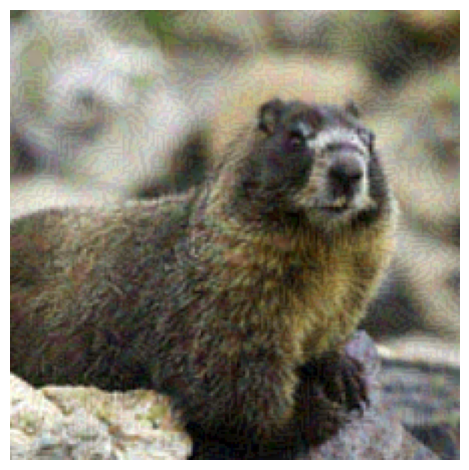

polecat 0.35426822
marmot 0.29965878
marmoset 0.09433842
weasel 0.056934454
titi 0.054335788


In [17]:
import torchattacks
import torchvision

atk = torchattacks.FGSM(AlexNet_FGSM, eps=8/255)
# atk = torchattacks.FFGSM(AlexNet_FGSM, eps=32/255, alpha=20/255)
adv_images = atk(Normalize_Image_FGSM(img), torch.tensor([335])) #class Marmot
adv_images = np.transpose(adv_images.squeeze().cpu().detach().numpy(), (1,2,0))
adv_img = Image.fromarray(np.uint8(255*adv_images)).convert('RGB')
plt.imshow(adv_img) #[::-1])
plt.axis('off')
plt.tight_layout()
plt.show()

predict_with_AlexNet(adv_img)

## Activity

That is scary! Neural networks are vulnerable to optical illusions too! We call these adversarial attacks. One way to avoid them is to incorporate these into the training process, basically as a form of data augmentation.

* Edit the code above to replace with your own image (maybe think about trying something where this would really matter - eg. a face recognition system or an autonomous driving setting) and attack the classifier.
* Try to find a more modern network online and replace Alexnet with this (eg. [ResNext](https://pytorch.org/hub/pytorch_vision_resnext/) or [MobileNet](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)). Does this do any better on the rotated image? 
